# Bikes theft model project

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive/")
    %cd "/content/gdrive/My Drive/Colab Notebooks/bikes-theft-model"

import numpy as np
import pandas as pd

import branca, geopandas
import folium # package for making maps, please make sure to use a version older than 1.0.0.
from folium.plugins import TimeSliderChoropleth

import ipywidgets
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


## Geographical data location

In this section we will present some statistics graphically according to their geopositional position, found in the database.

In [2]:
''' Important functions '''
# Read data & geomap with respect to city
def read_data_map(data_path, geo_path, city = None):
    skip_cols = ['City']
    
    # Read data of Toronto an Ottawa cities
    canada_data = pd.read_csv(data_path, dtype = {"GeoUID":str})
    if "GeoUID" in canada_data.columns:
        canada_data["GeoUID"] = canada_data["GeoUID"].apply(lambda x: x if len(x.split(".")[-1]) > 1 else x.replace(".0",".00")) # Fix important bug
    if city is not None:
        canada_data = canada_data[canada_data["City"] == city].drop(columns = skip_cols)
    
    if "%Theft/sqKm" in canada_data.columns:
        canada_data["%Theft/sqKm"] = canada_data["%Theft/sqKm"].replace({np.inf:0}) * 100
    if "%PopulationBike" in canada_data.columns:
        canada_data["%PopulationBike"] = canada_data["%PopulationBike"].replace({np.inf:0}) * 100
    
    # Read maps information
    canada_map = geopandas.read_file(geo_path, driver = "GeoJSON").rename(columns = {"id":"GeoUID"})
    return canada_data, canada_map

# Update pandas to geopandas
def to_geo(df):
    try:
        df_point = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.x, df.y)).set_crs("EPSG:4326")
    except:
        df_point = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.Long, df.Lat)).set_crs("EPSG:4326")
    return df_point

# Join geopandas with data with two possibles cases (with column or with points in polygon)
def mapJoinTable(df_point, df_map, how = "right", keep_geo_cols = False, print_info = True):
    if "GeoUID" in df_point:
        df_point["GeoUID"] = df_point["GeoUID"].astype(str); df_map["GeoUID"] = df_map["GeoUID"].astype(str)
        how = "left" if how == "right" else "right" if how == "left" else how # Change how method
        df_result = df_map.join(df_point.set_index("GeoUID"), how = how, on = "GeoUID")#.rename(columns = {"id":"GeoUID"})
    else:
        df_point = to_geo(df_point)
        df_result = geopandas.tools.sjoin(df_point, df_map, how = how)
    if not keep_geo_cols: df_result = df_result.drop(columns = df_map.columns.drop(["GeoUID","geometry"]))
    if print_info:
        print("[INFO] Map, unique GeoUID and merge data lenght, respectively:",len(df_map), len(df_result["GeoUID"].unique()), len(df_result))
        print("[INFO] Total data not-merge successfully:", len(df_result[df_result["geometry"].isnull()]))        
    return df_result.reset_index(drop=True)

# Plot a single map
def plotMap(df_geomap, value_var, caption = "Cost of bike by region", zoom_start = 10,
            name = 'Canada maps', fields2show = None, aliases = None, index = True):
    df_data_geomap = df_geomap.copy().fillna(0) 
    
    # Map creation colors
    min_cn, max_cn = df_data_geomap[value_var].quantile([0.01,0.99]).apply(round, 2)
    index = df_data_geomap[value_var].quantile([0.2,0.4,0.6,0.8]) if index else None
    colormap = branca.colormap.LinearColormap(
        colors=['white','yellow','orange','red','darkred'], vmin=min_cn, vmax=max_cn, index = index
    )
    colormap.caption = caption
    
    # Geo map skeleton
    init_local = [z[0] for z in df_data_geomap.iloc[0]["geometry"].centroid.xy][::-1]
    geomap = folium.Map(location = init_local, zoom_start=zoom_start, tiles="OpenStreetMap")

    style_function = lambda x: {
        'fillColor': colormap(x['properties'][value_var]),
        'color': 'black', 'weight':2, 'fillOpacity':0.5
    }
    
    if fields2show is None: fields2show = list(df_data_geomap.columns.drop("geometry"))
    if aliases is None: aliases = fields2show.copy()
    stategeo = folium.GeoJson(df_data_geomap.to_json(), name=name, style_function = style_function,
        tooltip = folium.GeoJsonTooltip(fields = fields2show, aliases = aliases, localize=True)
    ).add_to(geomap)

    colormap.add_to(geomap)
    return geomap

### Data Merge
In this section, we describe how mix the theft-bikes-data into geomap position. We start reading the data and show them in geographical zone.

In [3]:
### Toronto
save, year = False, None
df, df_geomap = read_data_map("./Data/Bicycle_Thefts_Toronto.csv", "./Data/Maps/pop_toronto.geojson")
if save:
    df_new2 = mapJoinTable(df, df_geomap, "left")
    print(len(df_new2), len(df_new2[df_new2["GeoUID"].isnull()]), len(df_new2[df_new2["GeoUID"].notnull()]))
    df_new2[df_new2["GeoUID"].notnull()].drop(columns = "geometry").to_csv("./Data/Bicycle_Thefts_Toronto_geo.csv", index = False)
df_new2 = mapJoinTable(df, df_geomap, "right")
# display(df_new2, df_new2.columns)

# Geomap proof 
status = list(df_new2["Status"].unique())
df_new2["new_status"] = df_new2["Status"].apply(lambda x: status.index(x) + 1 if x == x else 0)
if year is not None: df_new2 = df_new2[df_new2["Occurrence_Year"] == year]
toro = plotMap(df_new2.groupby("GeoUID").head(1), value_var = "new_status", 
            caption = "Status", name = 'Canada maps', index=False,fields2show = ["Status"])

### Ottawa
df, df_geomap = read_data_map("./Data/Bicycle_Theft_Ottawa.csv", "./Data/Maps/pop_ottawa.geojson")
if save:
    df_new2 = mapJoinTable(df, df_geomap, "left")
    print(len(df_new2), len(df_new2[df_new2["GeoUID"].isnull()]), len(df_new2[df_new2["GeoUID"].notnull()]))
    df_new2[df_new2["GeoUID"].notnull()].drop(columns = "geometry").to_csv("./Data/Bicycle_Theft_Ottawa_geo.csv", index = False)
df_new2 = mapJoinTable(df, df_geomap, "right")
# display(df_new2, df_new2.columns)

# Geomap proof 
status = list(df_new2["Bicycle_Status"].unique())
df_new2["new_status"] = df_new2["Bicycle_Status"].apply(lambda x: status.index(x) + 1 if x == x else 0)
if year is not None: df_new2 = df_new2[df_new2["Report_Date"].str.contains(str(year))]
otaw = plotMap(df_new2.groupby("GeoUID").head(1), value_var = "new_status", 
            caption = "Bicycle_Status", name = 'Canada maps', index=False)

# Show map
toro
# otaw

[INFO] Map, unique GeoUID and merge data lenght, respectively: 572 572 21589
[INFO] Total data not-merge successfully: 0
[INFO] Map, unique GeoUID and merge data lenght, respectively: 188 188 5652
[INFO] Total data not-merge successfully: 0


### Geojson incorporation

Now, let's trying to plot a geojson file and function to join data with map.

In order to be able to plot the geographical maps of Toronto and Ottawa, the function of `plotMap` was defined, which plots the map of the filtered city and a specific time. To facilitate the process, functions were defined to make the reading of the data and the maps (`read_data_map`), as well as a function to correlate the geopositional information with their respective information (`mapJoinTable`). 

To understand better the use of the functions, let's see a simple example of how to use them. Let's take the city of Toronto as an example. To do this, let's take the city of Toronto as an example and filter it by the hour with the highest records of theft. Finally, let's join the two tables and see what happens.

In [4]:
# Read geojson/data and put in pandas dataframe
toronto_data, toronto_map = read_data_map(data_path = "./Data/Stolen_bikes_johan_2016.csv", 
                                        geo_path = "./Data/Maps/pop_toronto.geojson", 
                                        city = "Toronto")

toronto_data_geomap = mapJoinTable(toronto_data, toronto_map, how = "right")
# display(toronto_data_geomap.head().append(toronto_data_geomap.tail()), toronto_data_geomap.shape, toronto_data_geomap.columns)

# For demo
max_hour = toronto_data_geomap.groupby("Hour").size().idxmax()
toronto_data_demo = toronto_data_geomap[toronto_data_geomap["Hour"] == max_hour].copy() # Important data = Demo
display(toronto_data_demo.head().append(toronto_data_demo.tail()), toronto_data_demo.shape, toronto_data_demo.columns)

[INFO] Map, unique GeoUID and merge data lenght, respectively: 572 572 2209
[INFO] Total data not-merge successfully: 0


,GeoUID,geometry,Unnamed: 0,Hour,PopulationCT,BicycleT,Area(sqKm),SumThBikes,BikesThDensity,BikesDensity,PopulationDensity,%Theft/sqKm,%PopulationBike
16,5350164.00,"MULTIPOLYGON (((-79.43183 43.68881, -79.43125 ...",2181.0,12.0,6258.0,195.0,0.62823,1.0,1.591774,310.395874,9961.319899,0.512821,3.116012
49,5350071.00,"MULTIPOLYGON (((-79.35029 43.67130, -79.35278 ...",1694.0,12.0,3481.0,185.0,0.46398,4.0,8.621061,398.724083,7502.478555,2.162162,5.314565
64,5350010.02,"MULTIPOLYGON (((-79.41122 43.64012, -79.41318 ...",842.0,12.0,7740.0,370.0,0.54735,4.0,7.307938,675.984288,14140.860510,1.081081,4.780362
75,5350010.01,"MULTIPOLYGON (((-79.41122 43.64012, -79.41459 ...",823.0,12.0,5428.0,225.0,0.26263,2.0,7.615276,856.718577,20667.859727,0.888889,4.145173
90,5350075.00,"MULTIPOLYGON (((-79.32966 43.67494, -79.33095 ...",1730.0,12.0,4083.0,125.0,0.49858,2.0,4.011392,250.712022,8189.257491,1.600000,3.061474
2135,5350073.00,"MULTIPOLYGON (((-79.34227 43.66775, -79.34188 ...",1712.0,12.0,2605.0,80.0,0.35718,1.0,2.799709,223.976706,7293.241503,1.250000,3.071017
2143,5350074.00,"MULTIPOLYGON (((-79.32801 43.67092, -79.32966 ...",1720.0,12.0,3848.0,205.0,0.39980,1.0,2.501251,512.756378,9624.812406,0.487805,5.327443
2162,5350052.00,"MULTIPOLYGON (((-79.44384 43.65086, -79.44532 ...",1430.0,12.0,4077.0,295.0,0.50129,1.0,1.994853,588.481717,8133.016817,0.338983,7.235713
2182,5350196.02,"MULTIPOLYGON (((-79.36929 43.71167, -79.36892 ...",2289.0,12.0,5635.0,75.0,1.10548,1.0,0.904584,67.843833,5097.333285,1.333333,1.330967
2204,5350063.06,"MULTIPOLYGON (((-79.38309 43.66137, -79.38504 ...",1610.0,12.0,5171.0,130.0,0.19221,4.0,20.810572,676.343583,26902.866656,3.076923,2.514020


(128, 13)

Index(['GeoUID', 'geometry', 'Unnamed: 0', 'Hour', 'PopulationCT', 'BicycleT',
       'Area(sqKm)', 'SumThBikes', 'BikesThDensity', 'BikesDensity',
       'PopulationDensity', '%Theft/sqKm', '%PopulationBike'],
      dtype='object')

#### Analysis in the maximum hour

We observe the lack of information with the `NaN` values. This information, for these specific hours was not available. For other values, let's plot the heatmap by region, using as an analysis variable the density of the percentage of thefts per hour.

In [5]:
print("[INFO]: Hour =", max_hour)
fields = toronto_data_demo.columns.drop(['GeoUID', 'Hour', 'Unnamed: 0', 'geometry']).to_list()
plotMap(toronto_data_demo, value_var = "%Theft/sqKm", caption = "%Theft/sqKm of bike by region", 
        name = 'Canada maps', index = False, fields2show = fields)

[INFO]: Hour = 12.0


#### Geopositioning analysis by year

With the little information available for this specific hour, we can see that the percentage density of thefts (to a greater extent) occurred outside. Additionally, the states with the highest density of robberies are some of the largest, due to the high population that is usually concentrated in regions with high volume density. 

Let's define now a more general procedure to visualize any region, indicating a specific year and the target city.

In [6]:
# Plot animation of every year
def update_geomap_year(year, hour, city):
    geo_path = "./Data/Maps/pop_{}.geojson".format(city.lower())
    data_path = "./Data/Stolen_bikes_johan_{}.csv".format(year)
    canada_data, canada_map = read_data_map(data_path = data_path, geo_path = geo_path, city = city)
    canada_data = canada_data[canada_data["Hour"] == hour].copy() # Keep important info
    canada_data_geomap = mapJoinTable(canada_data, canada_map, how = "right")
    
    if len(canada_data_geomap) == 0:
        return "[INFO] Not data for this combination"
    fields = canada_data_geomap.columns.drop(['GeoUID', 'Hour', 'geometry']).to_list()
    plotm = plotMap(canada_data_geomap, value_var = "%Theft/sqKm", caption = "%Theft/sqKm of bike by region", 
            name = 'Canada maps', fields2show = fields, aliases = fields, zoom_start = 11)
    display(plotm)

# Animation
anima_parameters = {
    "year": ipywidgets.IntSlider(min=2014, max=2019, step=1, style = {"handle_color":"lightblue"}),
    "hour": ipywidgets.IntSlider(min=0, max=24, step=1, style = {"handle_color":"lightblue"}),
    "city": ipywidgets.Dropdown(options = ["Toronto", "Ottawa"], value = 'Toronto', description = 'City', visible = True)
}

widget = ipywidgets.interactive_output(update_geomap_year, anima_parameters)
controls = ipywidgets.HBox(list(anima_parameters.values()), layout = ipywidgets.Layout(flex_flow='row wrap'))
ipywidgets.VBox([controls, widget])

#### General geopositioning analysis per hour

Finally, to make a more reliable analysis, let's look at the behavior of the two cities through the different times of day of all the years available.

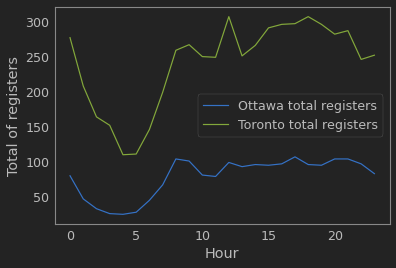

In [7]:
slider_dict_result = {}

for iax, city in enumerate(["Ottawa", "Toronto"]):
    for i, year in enumerate(["2014", "2015", "2016", "2017", "2018", "2019"]):
        data_path = "./Data/Stolen_bikes_johan_{}.csv".format(year)
        geo_path = "./Data/Maps/pop_{}.geojson".format(city.lower())
        data, canada_map = read_data_map(data_path, geo_path, city)
#         data["year"] = year
        if i == 0: canada_data = data.copy()
        else: canada_data = canada_data.append(data) # Join all data in just one table
    
    canada_data = canada_data.groupby(["GeoUID", "Hour"]).agg(np.mean).reset_index()
    
#     display(canada_data.head().append(canada_data.tail()), canada_data.shape, canada_data.columns)
    
    slider_dict_result[city] = {}; hours_reg = []
    for h in canada_data["Hour"].sort_values().unique(): # Save each graph by hour
        data = canada_data[canada_data["Hour"] == h].copy()
        hours_reg.append(len(data))
        data = mapJoinTable(data, canada_map, how = "right", print_info = False)
        if len(data) == 0: continue # NaN hour
        fields = data.columns.drop(['GeoUID', 'Hour', 'geometry']).to_list()
        plotmap = plotMap(data, value_var = "%Theft/sqKm", caption = "%Theft/sqKm of bike by region", 
            name = 'Canada maps', fields2show = fields, zoom_start = 11)
        slider_dict_result[city][str(int(h))] = plotmap
    
    plt.plot(hours_reg, label = "{} total registers".format(city))

plt.xlabel("Hour"); plt.ylabel("Total of registers")
plt.legend(); plt.grid(); plt.show()

In [8]:
# Plot animation of every year
def update_geomap_year(hour, city):
    display(slider_dict_result[city][str(hour)])

# Animation
anima_parameters = {
    "hour": ipywidgets.IntSlider(min=0, max=24, step=1, style = {"handle_color":"lightblue"}),
    "city": ipywidgets.Dropdown(options = ["Toronto", "Ottawa"], value = 'Toronto', description = 'City', visible = True)
}

widget = ipywidgets.interactive_output(update_geomap_year, anima_parameters)
controls = ipywidgets.HBox(list(anima_parameters.values()), layout = ipywidgets.Layout(flex_flow='row wrap'))
ipywidgets.VBox([controls, widget])

By the 17th hour, through the years, we see that the city of Ottawa has a higher density of robberies tending again to the outskirts of the city. With this information, we could start the corresponding investigations to find out the cause of this. Possibly it is easier for bicycle thieves to steal at these extremes, or it may be due to a socio-economic factor.

On the other hand, the density of robberies per area is a little more uniform in the city of Toronto, compared to the city of Ottawa. Despite the lack of information in this city, we can observe certain patterns of behavior over the years as groups of regions with high rates of theft in the center and north-center of the city.

By comparing the two cities we can ensure that there is more confidence in the data for the city of Toronto (as we have more information for this city). Additionally, a factor to consider is the maximum density value between the two cities. For the city of Ottawa, we have a percentage of 10% stolen cycles per km$^2$, in contrast to the city of Toronto with a percentage of 20% (double), which indicates that of each cycle stolen in Ottawa per area, two cycles are stolen in Toronto. 